In [1]:
import pyarrow.parquet as pq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pq.read_table(source='D:/mashob/0_processed.parquet').to_pandas()

In [3]:
df.head(3)

,title,text_markdown,pluses,minuses,id,author_id,username,url,tags
7,рассада,аня волос нос расти петя аня жопа рассада петя...,5,14,2936217,453525,Misochkin,https://pikabu.ru/story/rassada_2936217,Петр;Анна;Рассада;Волосы;Текст;Переписка;Знако...
11,начальник обед,родственница жаловаться дурдом работа трудитьс...,681,40,6991412,1699826,FluffyMagpie,https://pikabu.ru/story/pro_nachalnikov_i_obed...,Начальник;Руководитель;Обед;Еда;Сотрудники;Текст
15,помогать поиск игра,добрый сутки господин дама подсказывать назван...,2,10,6991359,878346,Keeeesha,https://pikabu.ru/story/pomogite_pozhaluysta_p...,Игры;Мобильное приложение;Гонки;Без рейтинга;П...


In [4]:
len(df)

5121

# Filtered data

Find index of those rows in which the pluses or minuses are not the real value

In [4]:
filtered_df = df[~(((df['minuses'] == 0) & (df['pluses'] == 0)) | (df['minuses'] < 0) | (df['pluses'] < 0))].copy()

In [6]:
len(filtered_df)

4448

In [5]:
def wilson_score(pluses: int, minuses: int, eps: float = 1e-7) -> float:
    n = pluses + minuses
    if n == 0:
        return 0
    p = pluses / (n + eps)
    return _wilson_score(p, n)

def _wilson_score(p: int, n: int) -> float:
    q = 1.96
    return (p + q**2 / (2*n) - q*np.sqrt((p*(1 - p) + q**2/(4*n)) / n)) / (1 + q**2/n)

In [6]:
filtered_df['rating'] = df.apply(lambda row: wilson_score(row['pluses'], row['minuses']), axis=1)

C:\Users\mashu\AppData\Local\Temp\ipykernel_19336\3075728088.py:10: RuntimeWarning: invalid value encountered in sqrt
  return (p + q**2 / (2*n) - q*np.sqrt((p*(1 - p) + q**2/(4*n)) / n)) / (1 + q**2/n)


In [9]:
pd.isnull(filtered_df.rating).count()

4448

Text(0, 0.5, 'Number of posts')

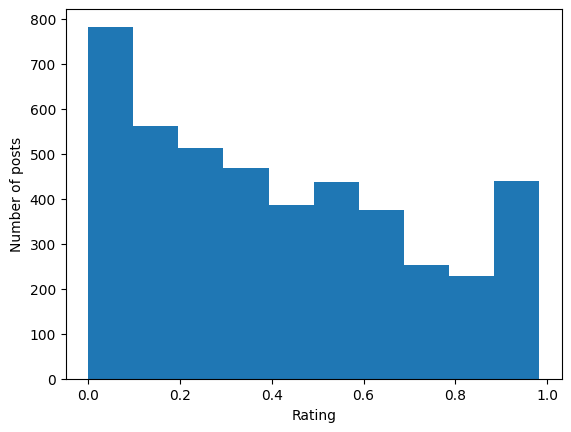

In [10]:
plt.hist(filtered_df.rating)
plt.xlabel('Rating')
plt.ylabel('Number of posts')

# To predict the rating: values ​​​​from 0 to 1, we solve the regression problem

# Gradient Boosting

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df.text_markdown, filtered_df.rating, test_size=0.2, random_state=42)

In [74]:
X_train_text = X_train.values
X_test_text = X_test.values
y_train = y_train.values
y_test = y_test.values

In [75]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector = v.fit_transform(X_train_text)
X_test_vector = v.transform(X_test_text)

In [15]:
params = {'n_estimators':500,
          'max_depth':5,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16,
          'random_state':42,
          }

In [16]:
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train_vector, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, min_samples_leaf=16,
                          min_samples_split=16, n_estimators=500,
                          random_state=42)

In [18]:
train_accuracy_score=gbr.score(X_train_vector,y_train)
print(train_accuracy_score)

0.5196913288111931


In [19]:
test_accuracy_score=gbr.score(X_test_vector,y_test)
print(test_accuracy_score)

0.20114199515714948


In [31]:
y_pred = gbr.predict(X_test_vector)

In [32]:
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_grad_boost = r2_score(y_test,y_pred)
print("R^2: ", r2_grad_boost)

RMSE: 0.26
R^2:  0.20114199515714948


# Catboost

In [7]:
from catboost import CatBoostRegressor

In [105]:
catboost_model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=6,
                          random_state=42)

In [106]:
catboost_model.fit(X_train_vector, y_train, eval_set=(X_test_vector, y_test))

0:	learn: 0.2886518	test: 0.2915257	best: 0.2915257 (0)	total: 11.2ms	remaining: 11.2s
1:	learn: 0.2858728	test: 0.2895457	best: 0.2895457 (1)	total: 19.1ms	remaining: 9.53s
2:	learn: 0.2836271	test: 0.2877699	best: 0.2877699 (2)	total: 28.4ms	remaining: 9.43s
3:	learn: 0.2813029	test: 0.2860016	best: 0.2860016 (3)	total: 34.9ms	remaining: 8.69s
4:	learn: 0.2793337	test: 0.2842104	best: 0.2842104 (4)	total: 43.3ms	remaining: 8.62s
5:	learn: 0.2774358	test: 0.2826884	best: 0.2826884 (5)	total: 49.4ms	remaining: 8.19s
6:	learn: 0.2758207	test: 0.2817549	best: 0.2817549 (6)	total: 56.9ms	remaining: 8.08s
7:	learn: 0.2741540	test: 0.2801734	best: 0.2801734 (7)	total: 62.9ms	remaining: 7.8s
8:	learn: 0.2727440	test: 0.2790626	best: 0.2790626 (8)	total: 69.8ms	remaining: 7.69s
9:	learn: 0.2712983	test: 0.2777817	best: 0.2777817 (9)	total: 75.6ms	remaining: 7.48s
10:	learn: 0.2699182	test: 0.2765098	best: 0.2765098 (10)	total: 82ms	remaining: 7.38s
11:	learn: 0.2686627	test: 0.2758652	best: 0

In [107]:
y_pred = catboost_model.predict(X_test_vector)

In [108]:
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_cat_boost = r2_score(y_test,y_pred)
print("R^2: ", r2_cat_boost)

RMSE: 0.26
R^2:  0.23689535483001545


# Let features = 'tags'

In [33]:
X_train_tags, X_test_tags, y_train, y_test = train_test_split(filtered_df.tags, filtered_df.rating, test_size=0.2, random_state=42)

In [34]:
X_train_text_tags = X_train_tags.values
X_test_text_tags = X_test_tags.values
y_train = y_train.values
y_test = y_test.values

In [35]:
v = TfidfVectorizer(norm=None, max_df=0.8, max_features=500, decode_error='replace')
X_train_vector_tags = v.fit_transform(X_train_text_tags)
X_test_vector_tags = v.transform(X_test_text_tags)

In [36]:
params = {'n_estimators':500,
          'max_depth':10,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16,
          'random_state':42,
          }

In [37]:
gbr_tags = GradientBoostingRegressor(**params)
gbr_tags.fit(X_train_vector_tags, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=10, min_samples_leaf=16,
                          min_samples_split=16, n_estimators=500,
                          random_state=42)

In [38]:
train_accuracy_score=gbr_tags.score(X_train_vector_tags,y_train)
print(train_accuracy_score)

0.23090115635457564


In [39]:
test_accuracy_score=gbr_tags.score(X_test_vector_tags,y_test)
print(test_accuracy_score)

0.12075726600237024


In [40]:
y_pred = gbr_tags.predict(X_test_vector_tags)
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
print("R^2: ", r2_score(y_test,y_pred))

RMSE: 0.28
R^2:  0.12075726600237024


# Use w2v to create embeddings

model Word2Vec from Gensim.

In [52]:
from gensim.models import Word2Vec

In [53]:
w2v_model = Word2Vec(min_count=10, window=2, vector_size=300, negative=10, alpha=0.03, min_alpha=0.0007, sample=6e-5, sg=1)

### Create function for splitting the text of each row into words

In [47]:
import pandas as pd
import re

def get_vocab(text: pd.core.series.Series) -> list:
    stop_words = ['тот', 'который', 'которая']
    words = re.findall(r'\w+', text.lower())
    filtered_words = [word for word in words if not re.match(r'^[a-zA-Z]+$', word) and word not in stop_words]
    return filtered_words

In [54]:
data = filtered_df.text_markdown.apply(get_vocab)

In [55]:
data

7        [аня, волос, нос, расти, петя, аня, жопа, расс...
11       [родственница, жаловаться, дурдом, работа, тру...
15       [добрый, сутки, господин, дама, подсказывать, ...
23       [негр, ходить, больница, читать, рэп, едит, ин...
28       [жук, мужик, российский, ржаной, гречневый, ал...
                               ...                        
22987    [глава, владлен, посмотреть, здание, час, часы...
22988    [мариуполь, зачистка, хунта, уничтожать, репут...
22992    [проходить, день, расставание, первый, единств...
22995    [напоминать, ставить, репост, друг, предел, рф...
22996    [перенести, сейв, ведьмак, первый, третий, пк,...
Name: text_markdown, Length: 4448, dtype: object

In [56]:
w2v_model.build_vocab(data)

In [57]:
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(10294748, 18207960)

In [58]:
w2v_model.save("word2vec.model")

In [74]:
w2v_model.wv.most_similar(positive=["политика"])

[('постсоветский', 0.44626644253730774),
 ('либеральный', 0.4457169473171234),
 ('тенденция', 0.4262751638889313),
 ('конференция', 0.41633734107017517),
 ('внешний', 0.4147883355617523),
 ('мишустин', 0.4081275761127472),
 ('неправильный', 0.4044887125492096),
 ('срака', 0.4031446874141693),
 ('элита', 0.3984372615814209),
 ('обсуждаться', 0.39317405223846436)]

In [60]:
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv))

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, filtered_df.rating, test_size=0.2, random_state=42)
X_train_text = X_train.values
X_test_text = X_test.values
y_train = y_train.values
y_test = y_test.values

In [63]:
train_tdidf = tfidf_vectorizer(w2v).fit(X_train_text).transform(X_train_text)

In [64]:
test_tdidf = tfidf_vectorizer(w2v).fit(X_test_text).transform(X_test_text)

In [43]:
test_tdidf.shape[0] + train_tdidf.shape[0] == len(filtered_df.text_markdown)

True

In [44]:
params = {'n_estimators':500,
          'max_depth':5,
          'criterion':'friedman_mse',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16,
          'random_state':42,
          }

In [45]:
gbr_w2v = GradientBoostingRegressor(**params)
gbr_w2v.fit(train_tdidf, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, min_samples_leaf=16,
                          min_samples_split=16, n_estimators=500,
                          random_state=42)

In [46]:
y_pred = gbr_w2v.predict(test_tdidf)
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_grad_boost_w2v = r2_score(y_test,y_pred)
print("R^2: ", r2_grad_boost_w2v)

RMSE: 0.26
R^2:  0.21477874286326715


Value R^2 increased by 0.0258 due to use of word2vec to obtain embeddings.

##### Now let`s train catboostRegressor on our embeddings.

In [45]:
catboost_model = CatBoostRegressor(iterations=300,
                          learning_rate=0.07,
                          depth=4,
                          random_state=42)

catboost_model.fit(train_tdidf, y_train, eval_set=(test_tdidf, y_test))

0:	learn: 0.2902436	test: 0.2924790	best: 0.2924790 (0)	total: 30ms	remaining: 8.98s
1:	learn: 0.2885270	test: 0.2905570	best: 0.2905570 (1)	total: 47.9ms	remaining: 7.14s
2:	learn: 0.2867047	test: 0.2887032	best: 0.2887032 (2)	total: 69ms	remaining: 6.83s
3:	learn: 0.2851565	test: 0.2869502	best: 0.2869502 (3)	total: 84.8ms	remaining: 6.28s
4:	learn: 0.2836530	test: 0.2854465	best: 0.2854465 (4)	total: 104ms	remaining: 6.13s
5:	learn: 0.2821286	test: 0.2839287	best: 0.2839287 (5)	total: 123ms	remaining: 6.04s
6:	learn: 0.2808412	test: 0.2831483	best: 0.2831483 (6)	total: 138ms	remaining: 5.78s
7:	learn: 0.2794729	test: 0.2818647	best: 0.2818647 (7)	total: 156ms	remaining: 5.69s
8:	learn: 0.2780472	test: 0.2806333	best: 0.2806333 (8)	total: 171ms	remaining: 5.52s
9:	learn: 0.2769191	test: 0.2794617	best: 0.2794617 (9)	total: 184ms	remaining: 5.33s
10:	learn: 0.2757815	test: 0.2786540	best: 0.2786540 (10)	total: 200ms	remaining: 5.25s
11:	learn: 0.2747216	test: 0.2779021	best: 0.2779021

In [46]:
y_pred = catboost_model.predict(test_tdidf)
rmse = MSE(y_test,y_pred)**0.5
print("RMSE: %.2f" % rmse)
r2_cat_boost_w2v = r2_score(y_test,y_pred)
print("R^2: ", r2_cat_boost_w2v)

RMSE: 0.25
R^2:  0.24958543579089076


Value R^2 increased by 0.0127 due to use of word2vec to obtain embeddings

# R^2

In [72]:
index = ['without word2vec', 'with word2vec']
data_table = {'GradientBoosting': [r2_grad_boost, r2_grad_boost_w2v],
              'CatBoost': [r2_cat_boost, r2_cat_boost_w2v]}

df_r2 = pd.DataFrame(data_table, index=index)
print(df_r2)

                  GradientBoosting  CatBoost
without word2vec          0.201142  0.236895
with word2vec             0.226953  0.249585
